# Multi-layer Perceptron Classifier

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Load Split Data

In [3]:
clean_train = "../../data/clean/clean_train.csv"
clean_val = "../../data/clean/clean_val.csv"
clean_test = "../../data/clean/clean_test.csv"
train_subsam = "../../data/clean/train_subsam.csv"
train_smote = "../../data/clean/train_smote.csv"

num_cols = ["Term","NoEmp","SecuredSBA","GrDisburs","GrApprov","ApprovSBA"]
target = "Default"

In [4]:
df_train = pd.read_csv(clean_train, low_memory=False)
df_val = pd.read_csv(clean_val, low_memory=False)
df_test = pd.read_csv(clean_test, low_memory=False)

df_under = pd.read_csv(train_subsam, low_memory=False)
df_smote = pd.read_csv(train_smote, low_memory=False)

In [5]:
X_train = df_train.drop(columns=[target])
X_val = df_val.drop(columns=[target])
X_test = df_test.drop(columns=[target])
X_under = df_under.drop(columns=target)
X_smote = df_smote.drop(columns=target)

y_train = df_train[target]
y_val = df_val[target]
y_test = df_test[target]
y_under = df_under[target]
y_smote = df_smote[target]

# from tensorflow.keras.utils import to_categorical
# y_train = to_categorical(y_train, num_classes=2)

In [6]:
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val:   {X_val.shape}, {y_val.shape}")
print(f"Test:  {X_test.shape}, {y_test.shape}\n")

print(f"SubSam: {X_under.shape}, {y_under.shape}")
print(f"SMOTE:  {X_smote.shape}, {y_smote.shape}")

Train: (626670, 18), (626670,)
Val:   (134552, 18), (134552,)
Test:  (134498, 18), (134498,)

SubSam: (219654, 18), (219654,)
SMOTE:  (1033686, 18), (1033686,)


## Feature Scaling

In [7]:
scaler = MinMaxScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.fit_transform(X_val[num_cols])
X_test[num_cols] = scaler.fit_transform(X_test[num_cols])

df_under[num_cols] = scaler.fit_transform(df_under[num_cols])
df_smote[num_cols] = scaler.fit_transform(df_smote[num_cols])

X_train.sample(3)

,State,BankState,DifState,Sector,AppYear,AppMonth,Term,NoEmp,Secured,NewExist,Urban,Rural,RevLine,LowDoc,GrDisburs,GrApprov,ApprovSBA,SecuredSBA
357628,4,5,0,13,32,5,0.147627,0.0001,0,0,0,0,0,0,0.002272,0.005301,0.004295,0.793814
542860,4,5,0,16,46,2,0.147627,0.0001,0,1,0,1,0,0,0.002709,0.006215,0.005666,0.896907
182196,19,43,1,4,41,7,0.008787,0.0001,0,1,1,0,0,0,0.000040,0.000731,0.000366,0.484536


## Model Training

### Model Tuning

In [8]:
def create_model():
    model = keras.Sequential()

    model.add(layers.Dense(64, input_shape=[len(X_train.keys())], activation="relu"))
    model.add(layers.Dense(512, activation="relu"))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [9]:
mlp_model = create_model()

mlp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1216      
                                                                 
 dense_1 (Dense)             (None, 512)               33280     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 35009 (136.75 KB)
Trainable params: 35009 (136.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
history = mlp_model.fit(X_train,
                        y_train,
                        epochs=100,
                        batch_size=1000,
                        verbose=1,
                        validation_data=(X_val, y_val))

Epoch 1/100
627/627 [==============================] - 20s 28ms/step - loss: 0.4270 - accuracy: 0.8215 - val_loss: 0.3787 - val_accuracy: 0.8322
Epoch 2/100
627/627 [==============================] - 18s 28ms/step - loss: 0.3616 - accuracy: 0.8451 - val_loss: 0.3538 - val_accuracy: 0.8388
Epoch 3/100
627/627 [==============================] - 18s 29ms/step - loss: 0.3334 - accuracy: 0.8634 - val_loss: 0.3242 - val_accuracy: 0.8661
Epoch 4/100
627/627 [==============================] - 19s 30ms/step - loss: 0.3193 - accuracy: 0.8719 - val_loss: 0.3122 - val_accuracy: 0.8725
Epoch 5/100
627/627 [==============================] - 17s 27ms/step - loss: 0.3128 - accuracy: 0.8748 - val_loss: 0.3265 - val_accuracy: 0.8633
Epoch 6/100
627/627 [==============================] - 16s 25ms/step - loss: 0.3077 - accuracy: 0.8778 - val_loss: 0.3141 - val_accuracy: 0.8698
Epoch 7/100
627/627 [==============================] - 16s 25ms/step - loss: 0.3037 - accuracy: 0.8797 - val_loss: 0.3195 - val_ac

In [11]:
results = mlp_model.evaluate(X_test, y_test, verbose=1)

print("Accuracy:", round(results[1], 4))

4204/4204 [==============================] - 13s 3ms/step - loss: 0.3045 - accuracy: 0.8981
Accuracy: 0.8981


In [12]:
df_hist = pd.DataFrame(history.history)
df_hist["epoch"] = history.epoch

df_hist.iloc[[0,1,-2,-1]]

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.426994,0.821522,0.378659,0.832154,0
1,0.361600,0.845121,0.353757,0.838776,1
98,0.222092,0.915632,0.247903,0.910904,98
99,0.221988,0.916075,0.237119,0.912019,99


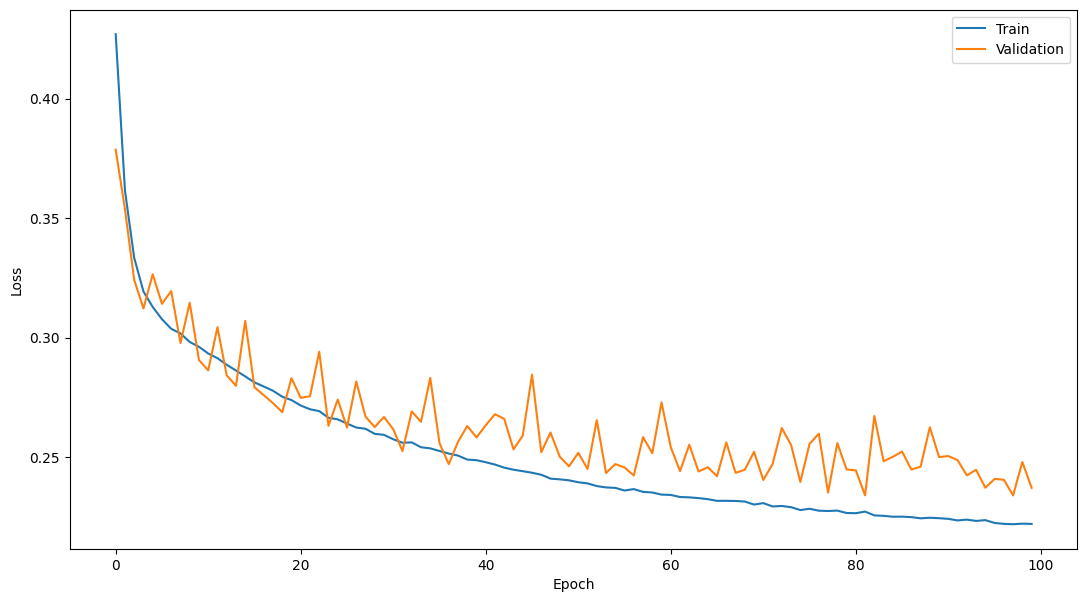

In [13]:
plt.figure(figsize=(13,7))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(df_hist["epoch"], df_hist["loss"], label="Train")
plt.plot(df_hist["epoch"], df_hist["val_loss"], label = "Validation")
plt.legend()
plt.show()

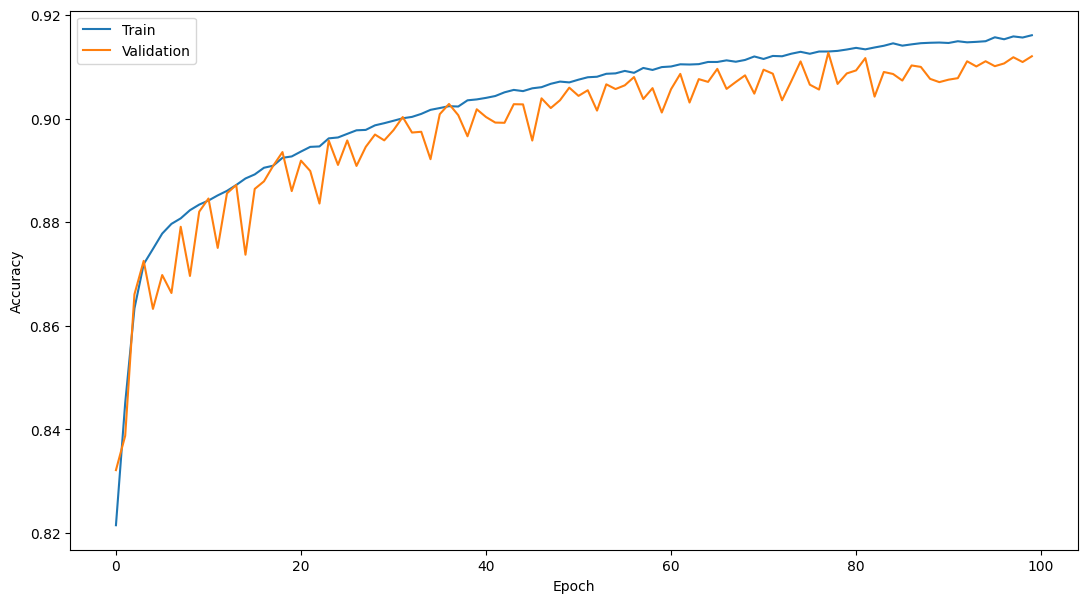

In [14]:
plt.figure(figsize=(13,7))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(df_hist["epoch"], df_hist["accuracy"], label="Train")
plt.plot(df_hist["epoch"], df_hist["val_accuracy"], label = "Validation")
plt.legend()
plt.show()

### Balanced Datasets

In [15]:
mlp_sam = create_model()

**Subsample Dataset**

In [ ]:
his_sam = mlp_sam.fit(X_under,
                      y_under,
                      epochs=100,
                      batch_size=1000,
                      verbose=1,
                      validation_data=(X_val, y_val))

Epoch 1/100
220/220 [==============================] - 3s 10ms/step - loss: 978.6343 - accuracy: 0.5403 - val_loss: 1.2381 - val_accuracy: 0.1844
Epoch 2/100
220/220 [==============================] - 2s 9ms/step - loss: 6.8598 - accuracy: 0.5545 - val_loss: 1.3842 - val_accuracy: 0.1771
Epoch 3/100
220/220 [==============================] - 2s 11ms/step - loss: 2.8397 - accuracy: 0.5784 - val_loss: 1.3876 - val_accuracy: 0.1771
Epoch 4/100
220/220 [==============================] - 2s 9ms/step - loss: 1.6435 - accuracy: 0.5887 - val_loss: 1.3889 - val_accuracy: 0.1771
Epoch 5/100
220/220 [==============================] - 2s 9ms/step - loss: 1.0087 - accuracy: 0.5914 - val_loss: 1.3942 - val_accuracy: 0.1771
Epoch 6/100
220/220 [==============================] - 2s 9ms/step - loss: 1.1692 - accuracy: 0.5912 - val_loss: 1.3547 - val_accuracy: 0.1771
Epoch 7/100
220/220 [==============================] - 2s 9ms/step - loss: 0.8174 - accuracy: 0.5912 - val_loss: 1.3410 - val_accuracy: 0.

In [ ]:
res_sam = mlp_sam.evaluate(X_test, y_test, verbose=1)

print("Accuracy SubSampling:", round(res_sam[1], 4))

4204/4204 [==============================] - 5s 1ms/step - loss: 1.1890 - accuracy: 0.1796
Accuracy SubSampling: 0.1796


**SMOTE Dataset**

In [ ]:
his_sam = mlp_sam.fit(X_smote,
                      y_smote,
                      epochs=100,
                      batch_size=1000,
                      verbose=1,
                      validation_data=(X_val, y_val))

Epoch 1/100
1034/1034 [==============================] - 8s 8ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 1.1627 - val_accuracy: 0.1790
Epoch 2/100
1034/1034 [==============================] - 8s 8ms/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 1.1645 - val_accuracy: 0.1789
Epoch 3/100
1034/1034 [==============================] - 8s 8ms/step - loss: 0.6931 - accuracy: 0.5004 - val_loss: 1.1552 - val_accuracy: 0.1790
Epoch 4/100
1034/1034 [==============================] - 8s 8ms/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 1.1573 - val_accuracy: 0.1789
Epoch 5/100
1034/1034 [==============================] - 8s 8ms/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 1.1526 - val_accuracy: 0.1792
Epoch 6/100
1034/1034 [==============================] - 8s 8ms/step - loss: 0.6932 - accuracy: 0.4992 - val_loss: 1.1596 - val_accuracy: 0.1788
Epoch 7/100
1034/1034 [==============================] - 8s 8ms/step - loss: 0.6931 - accuracy: 0.5004 - val_loss: 1.1584 - val_ac

In [ ]:
res_sam = mlp_sam.evaluate(X_test, y_test, verbose=1)

print("Accuracy SMOTE:", round(res_sam[1], 4))

4204/4204 [==============================] - 5s 1ms/step - loss: 1.0207 - accuracy: 0.2205
Accuracy SMOTE: 0.2205


## Model Evaluation

### Classification Report

In [16]:
y_pred = mlp_model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

4204/4204 [==============================] - 14s 3ms/step


In [17]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_test, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_pred, average="macro")))

Exactitud:    0.8981
Precisión:    0.8779


Sensibilidad: 0.7479
F1-score:     0.7913


In [18]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9036    0.9807    0.9406    110629
           1     0.8521    0.5150    0.6420     23869

    accuracy                         0.8981    134498
   macro avg     0.8779    0.7479    0.7913    134498
weighted avg     0.8945    0.8981    0.8876    134498



### Confusion Matrix

In [19]:
cm_mlp = confusion_matrix(y_test, y_pred, normalize="all")
print(cm_mlp)

[[0.80667371 0.01585897]
 [0.08606819 0.09139913]]


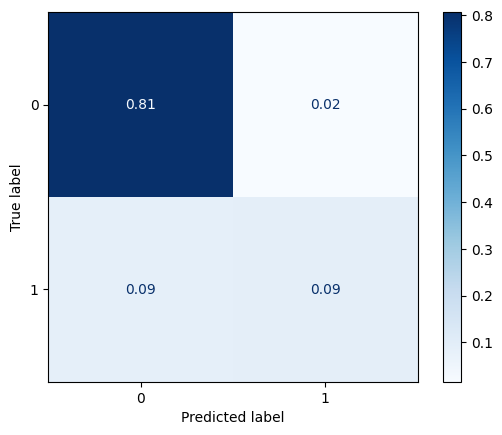

In [20]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp)
disp.plot(cmap="Blues", values_format=".2f")

### ROC Curve & AUC

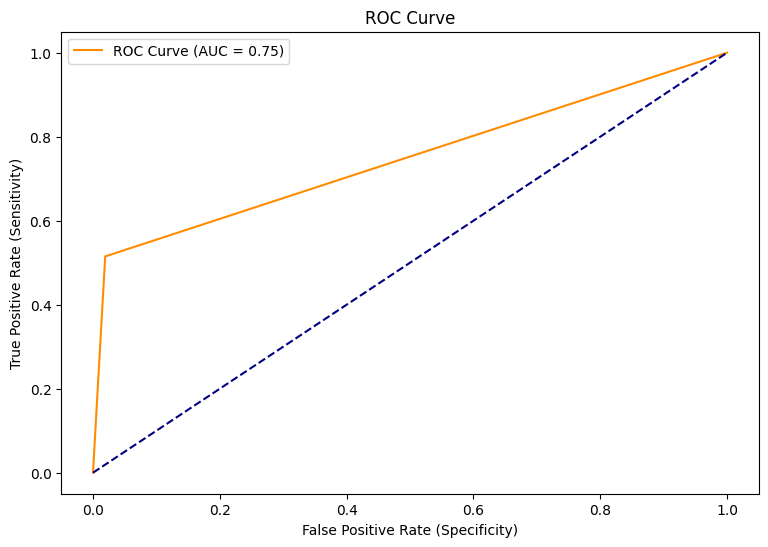

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9, 6))
plt.plot(fpr, tpr, color="darkorange", label="ROC Curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

plt.title("ROC Curve")
plt.xlabel("False Positive Rate (Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.legend()
plt.show()